In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
def normalize(df_train, df_val):
        # Step0 - Some preprocessing
    df_train_X = df_train[df_train.columns[:-1]]
    df_train_X = df_train_X.astype('float64', copy=True)
    train_X_norm = StandardScaler().fit_transform(df_train_X)
    
    return df_train_X, train_X_norm

def pca_helper(n_components, train_X_norm):
    pca = PCA(n_components = n_components)
    train_X_norm_PCA = pca.fit_transform(train_X_norm)
    return pca, train_X_norm_PCA

In [14]:
def meth_PCA(df_train, df_val, n_components, task4 = False, preserve_variance=0.99):
    df_train_X, train_X_norm = normalize(df_train, df_val)
    pca, train_X_norm_PCA = pca_helper(n_components=n_components, train_X_norm=train_X_norm)
    
    if n_components == 43:
        num_components = np.where(pca.explained_variance_ratio_.cumsum() > preserve_variance)[0][0]
        print ('Components needed (preserving ',preserve_variance, '% variance) : ', num_components)
    else:
        num_components = n_components
    
    train_X_norm_recon = pca.inverse_transform(train_X_norm_PCA)
    pca_diff           = train_X_norm - train_X_norm_recon
    pca_square         = np.square(pca_diff)
    pca_residual       = pca_square.sum(axis=1)
    
    f, axarr = plt.subplots(4,1, figsize = [15,15])

    y_axis = pca.explained_variance_ratio_.cumsum()
    x_axis = np.arange(1, train_X_norm_PCA.shape[1]+1)

    x_axis_1 = np.arange(1, train_X_norm_PCA.shape[1]+1, 1)
    axarr[3].set_xlabel('Principal Components')
    axarr[3].set_ylabel('Variance Captured')
    axarr[3].plot(x_axis_1, pca.explained_variance_ratio_)
    axarr[0].plot(x_axis, y_axis)
    axarr[0].set_xlabel('Principal Component')
    axarr[0].set_ylabel('Cumulative Variance')
    axarr[0].set_title('Variance Distribution : {0} components for {1}% variance'.format(num_components, preserve_variance))

    axarr[1].set_xlabel('Data - Train')
    axarr[1].set_ylabel('PCA Residual')
    axarr[1].plot(pca_residual)
    axarr[1].set_title('PCA Fit Residual')

    axarr[2].plot(df_val['ATT_FLAG'])
    axarr[1].set_title('val_y_true')

    plt.show()
    
    if (task4):
        max_index = np.argmax(pca_residual)
        where = np.where(pca_residual > 1000)
        index = where[0]
        print('Before abnormality removal: ', df_train.shape)
        for i in index:
            row = df_train.iloc[[i]]
            train = df_train.drop(row.index)
        print('After abnormality removal: ', df_train.shape)
        
    return num_components



In [16]:
def PCA_to_sub(df_train, df_val, n_components, task4=False):        
    df_train_X, train_X_norm = normalize(df_train, df_val)
    pca, train_X_norm_PCA = pca_helper(n_components=n_components, train_X_norm=train_X_norm)


    eigVect = pca.components_
    P       = np.transpose(eigVect)
    P_T     = np.transpose(P)
    C       = np.dot(P, P_T)
    I       = np.identity(train_X_norm.shape[1])

    train_residual = np.zeros((train_X_norm.shape))
    for i in range(train_X_norm.shape[0]):
        y = np.transpose(train_X_norm[i])
        train_residual[i] = np.dot(I - C, y)
    pca_diff_train     = train_X_norm - train_residual
    pca_square_train   = np.square(pca_diff_train)
    pca_residual_train = pca_square_train.sum(axis=1)

    if (task4):
        out_indices      = np.where(pca_residual_train > 500)
        train_X_norm_new = np.delete(train_X_norm, out_indices, axis=0)

        pca = PCA(n_components = n_components)
        train_X_norm_PCA_new = pca.fit_transform(train_X_norm_new)
        eigVect = pca.components_
        P       = np.transpose(eigVect)
        P_T     = np.transpose(P)
        C       = np.dot(P, P_T)

    df_val_X = df_val[df_val.columns[:-1]]
    df_val_X = df_val_X.astype('float64', copy=True)
    val_X_norm = StandardScaler().fit_transform(df_val_X)
    I            = np.identity(val_X_norm.shape[1])
    val_residual = np.zeros((val_X_norm.shape))

    for i in range(val_X_norm.shape[0]):
        y = np.transpose(val_X_norm[i])
        val_residual[i] = np.dot(I - C, y)

    pca_diff_val = val_X_norm - val_residual
    pca_square_val = np.square(pca_diff_val)
    pca_residual_val = pca_square_val.sum(axis=1)

    threshold     = 80 
    val_y_true    = df_val['ATT_FLAG'].tolist()
    val_y_predict = np.copy(pca_residual_val)
    val_y_predict[val_y_predict < threshold]  = -999
    val_y_predict[val_y_predict >= threshold] = 1    
    val_y_predict = val_y_predict.astype(int)
    print (' - conf mat : \n', confusion_matrix(val_y_true, val_y_predict))
    tn, fp, fn, tp = confusion_matrix(val_y_true, val_y_predict).ravel()

    Accuracy=(tp+tn)/(tp+tn+fp+fn)*100
    Precision=tp / (tp + fp)*100
    Recall = tp / (tp + fn)*100
    F_score = 2*tp /(2*tp + fp + fn)*100
    print("Accuracy:","%.2f" % Accuracy)
    print("Precision:","%.2f" % Precision)
    print("Recall:", "%.2f" %Recall)
    print("F_score:","%.2f" % F_score)

    f,axarr = plt.subplots(4,1, figsize=(15,30))

    axarr[0].plot(pca_residual_train)
    axarr[0].set_title('Residual Plot - Train')

    axarr[1].plot(pca_residual_val)
    axarr[1].plot([0, len(pca_residual_val)], [threshold, threshold], 'r')
    axarr[1].set_title('Residual Plot - Validation')

    axarr[2].plot(val_y_predict)
    axarr[2].set_title('val_y_predict')

    axarr[3].plot(df_val['ATT_FLAG'])
    axarr[3].set_title('val_y_true')


    plt.show()

    return pca



Components needed (preserving  0.9 % variance) :  9


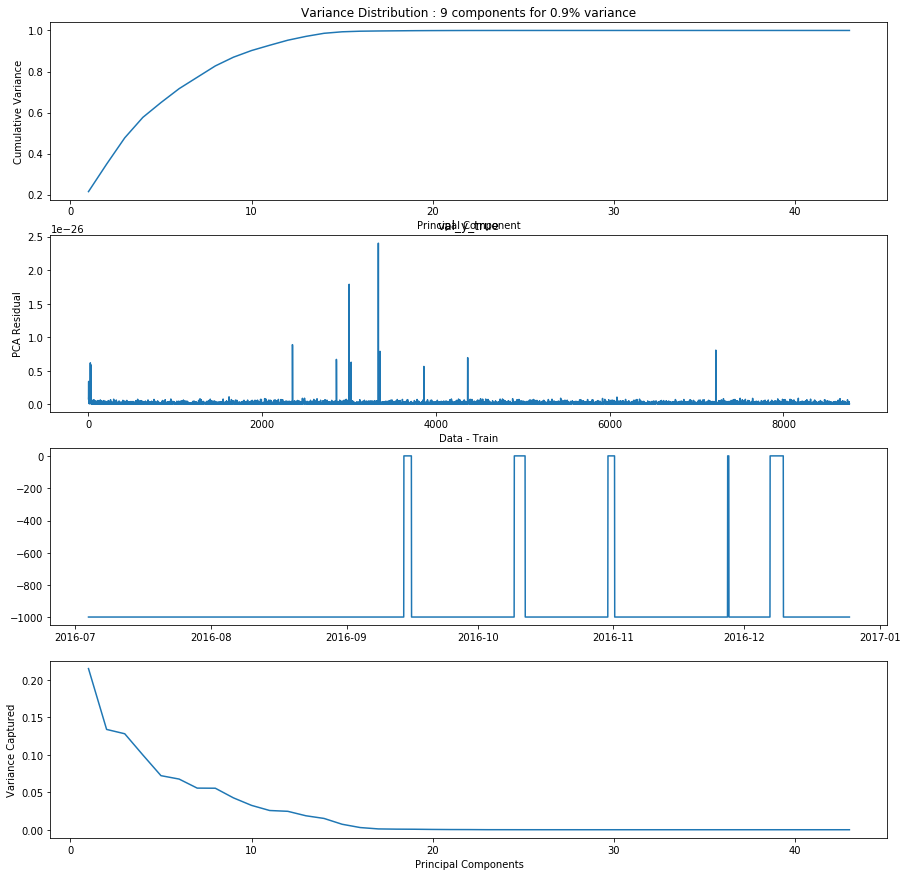

In [17]:
train_df = pd.read_csv('data/BATADAL_dataset03.csv', encoding="utf-8-sig",  delimiter=',', skipinitialspace=True, parse_dates=True, index_col='DATETIME', dayfirst=True)
val_df = pd.read_csv('data/BATADAL_dataset04.csv', encoding="utf-8-sig",  delimiter=',', skipinitialspace=True, parse_dates=True, index_col='DATETIME', dayfirst=True)

#Step 1
n_comp = meth_PCA(train_df, val_df, n_components=43, preserve_variance=0.90)


 - conf mat : 
 [[3919   39]
 [ 131   88]]
Accuracy: 95.93
Precision: 69.29
Recall: 40.18
F_score: 50.87


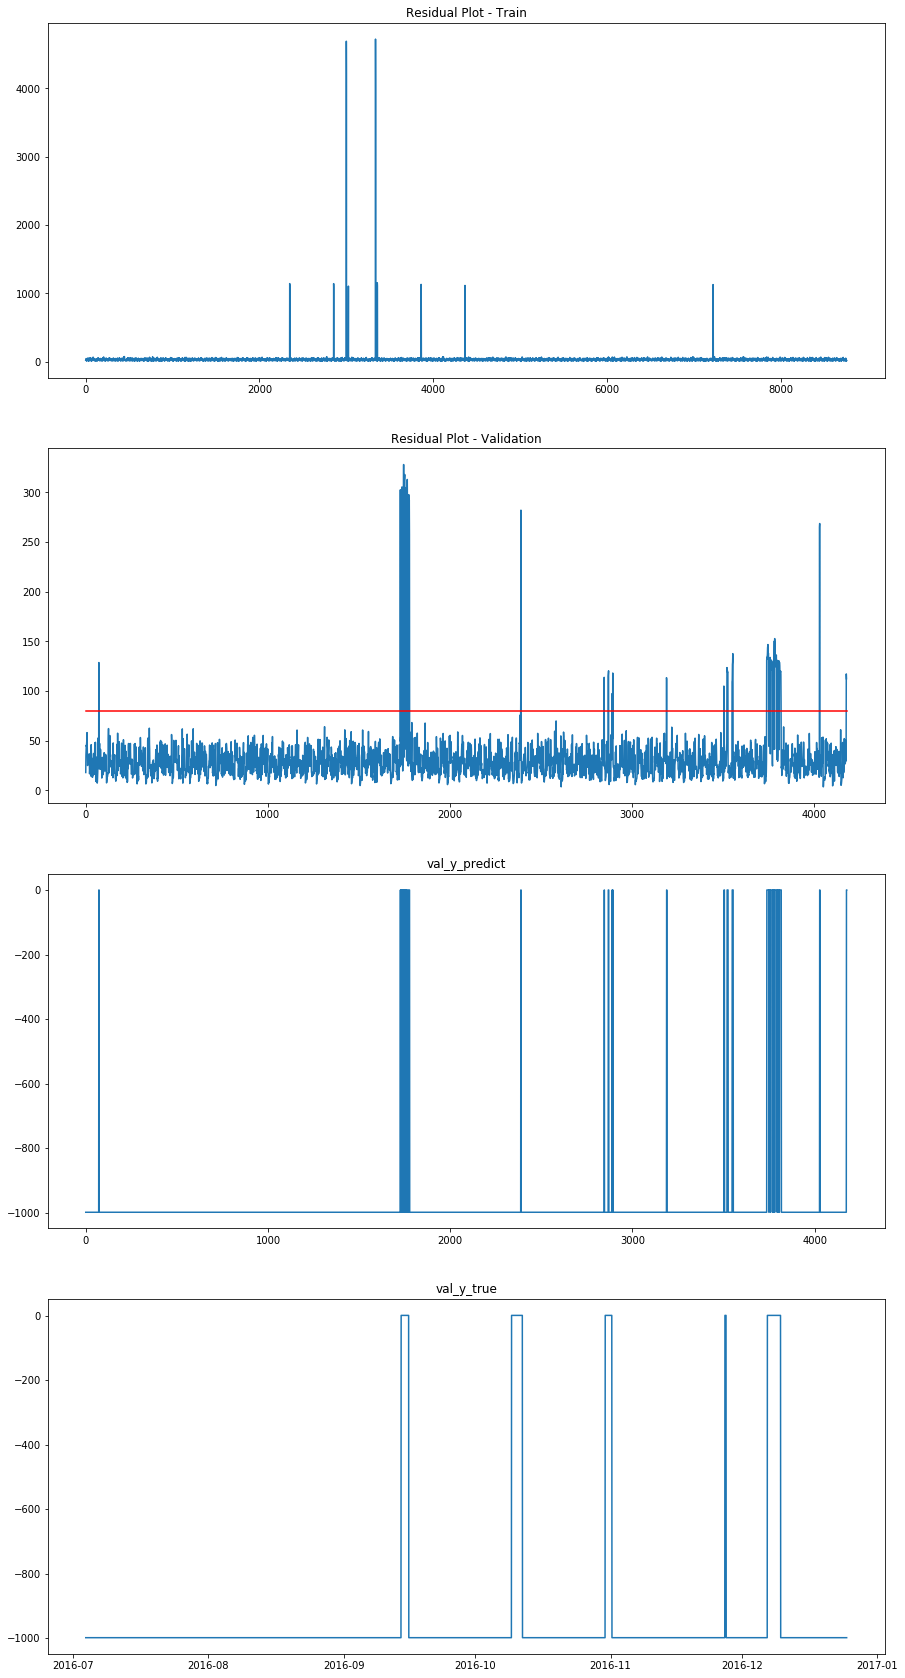

In [18]:
#step 2 and 3
pcaObj = PCA_to_sub(train_df, val_df, n_components=n_comp, task4=False)

Components needed (preserving  0.9 % variance) :  9


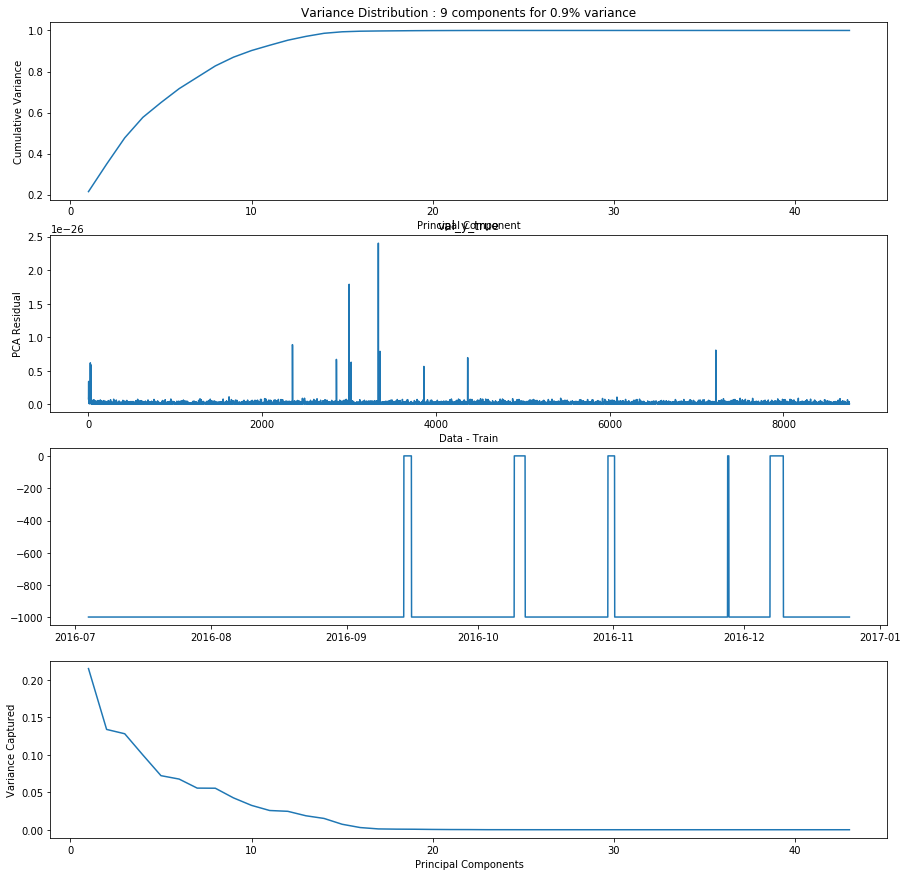

Before abnormality removal:  (8761, 44)
After abnormality removal:  (8761, 44)
 - conf mat : 
 [[3955    3]
 [ 214    5]]
Accuracy: 94.80
Precision: 62.50
Recall: 2.28
F_score: 4.41


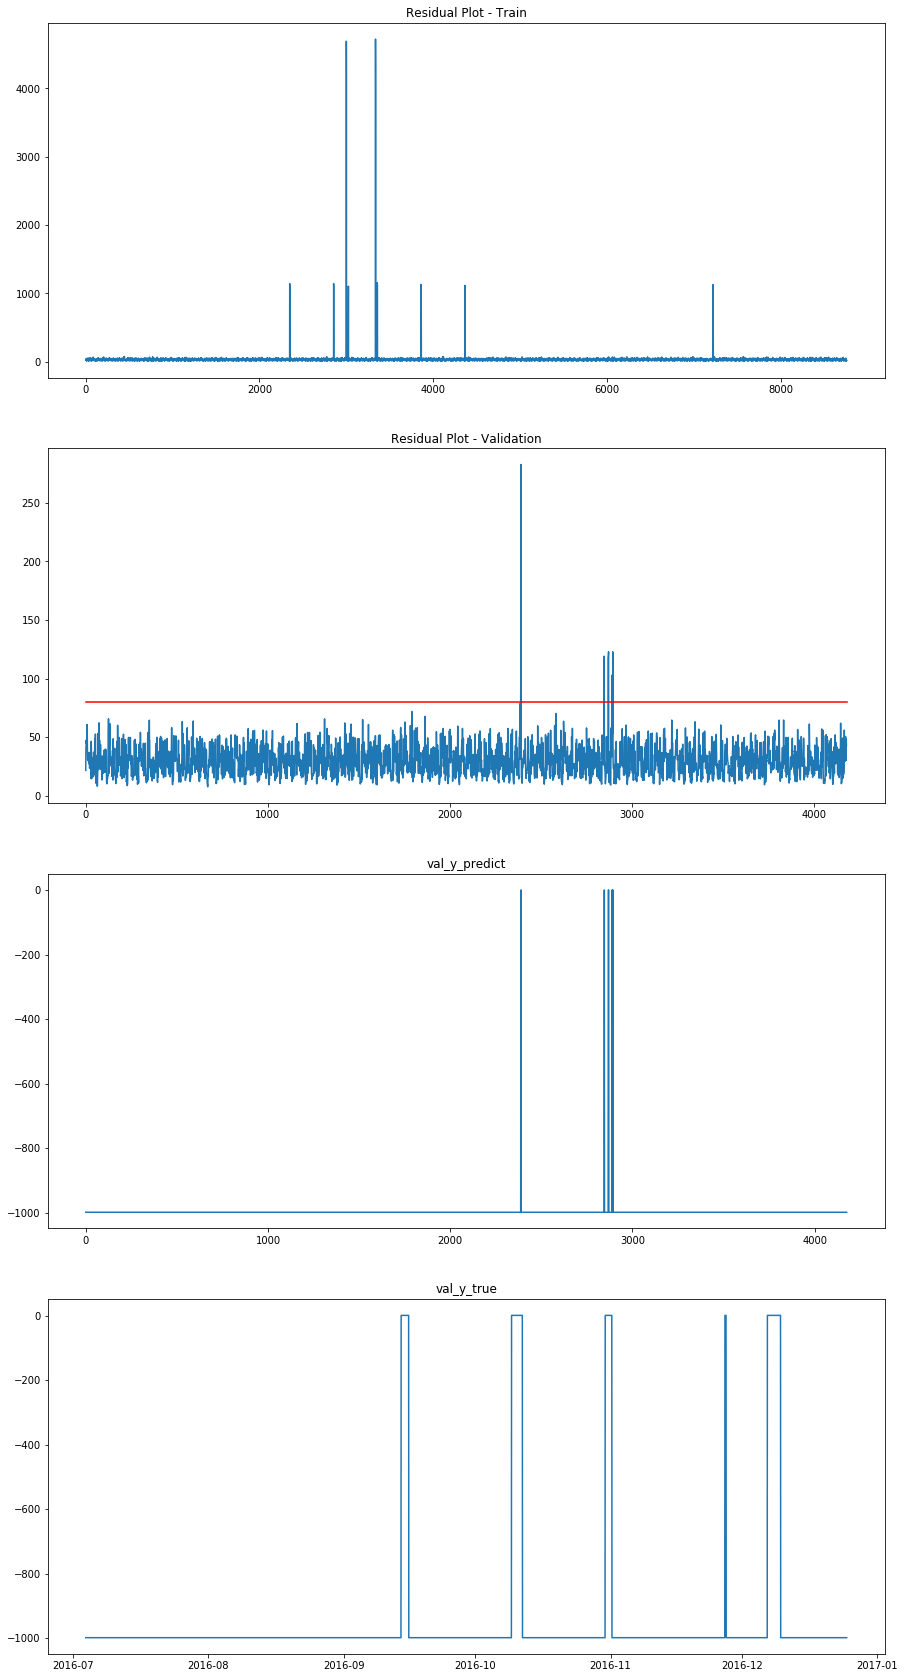

In [19]:
#Step 4 (remove large abonalies from training)
n_comp = meth_PCA(train_df, val_df, n_components=43, task4=True, preserve_variance=0.90)
pcaObj = PCA_to_sub(train_df, val_df, n_components=n_comp, task4=True)